# Using Trava for plots & models autotracking with MLFlow

### Note: MLFlow is only one of possible implementations of trava.tracker.Tracker interface. 

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np

### Get data

In [2]:
from sklearn import datasets

dataset = datasets.load_breast_cancer()
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
df['target'] = dataset['target']

### How to track plots with Trava

`PlotHandler` is responsible for showing plots for metrics and for tracking them. It's very easy to implement visualization for your metric, just look into `PlotItem` dataclass details.

In this case `ROCCurvesPlotItem` knows which metric is needed for calculating `ROC AUC` curve as well as how to draw it.

Just initialize `PlotHandler` with it and the plot will be saved as an artifact.

In [3]:
from trava.ext.sklearn.scorers import sk, sk_proba
from trava.ext.tracker.mlflow import MLFlowTracker
from trava.ext.results_handlers.plotter import PlotHandler
from trava.ext.plots.roc import ROCCurvesPlotItem

plot_handler = PlotHandler(plot_items=[ROCCurvesPlotItem()])

# we can pass an empty list for scorers since 
# now we are only interested in plots
tracker = MLFlowTracker(scorers=[])
# setting the new experiment
tracker.track_set_tracking_group(group='mlflow_demo')

INFO: 'mlflow_demo' does not exist. Creating a new experiment


### Split the data

Just `Trava's` way of making train/test splits.

In [4]:
from trava.ext.split_logic.basic import BasicSplitLogic
from trava.split.config import DataSplitConfig
from trava.split.result import SplitResult
from trava.split.splitter import Splitter

# Trava comes with some built-in options for splitting data,
# yet you can subclass trava.split.SplitLogic for something that suits you
split_config = DataSplitConfig(split_logic=BasicSplitLogic(shuffle=True),
                               target_col_name='target',
                               test_size=0.3)

split_result = Splitter.split(df=df, config=split_config)

### Initialize Trava

We use `TravaSV` instance to train and assess our models.

In [5]:
from trava.trava_sv import TravaSV

# This time we use results_handlers param, since we want Trava to visualize some metrics
trava = TravaSV(tracker=tracker, results_handlers=[plot_handler])

### Serializer

`Trava` must know how to serialize your model

In [6]:
from trava.ext.model_serializer.pickle import PickleModelSerializer

# you can easily write your own serializer
serializer = PickleModelSerializer()

### Training a model

To track a model we just need to pass a `serializer` instance in `fit_predict` function.

/Users/ilya.tyutin/anaconda3/lib/python3.7/site-packages/py4j/java_collections.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import (
/Users/ilya.tyutin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/ilya.tyutin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend

[]

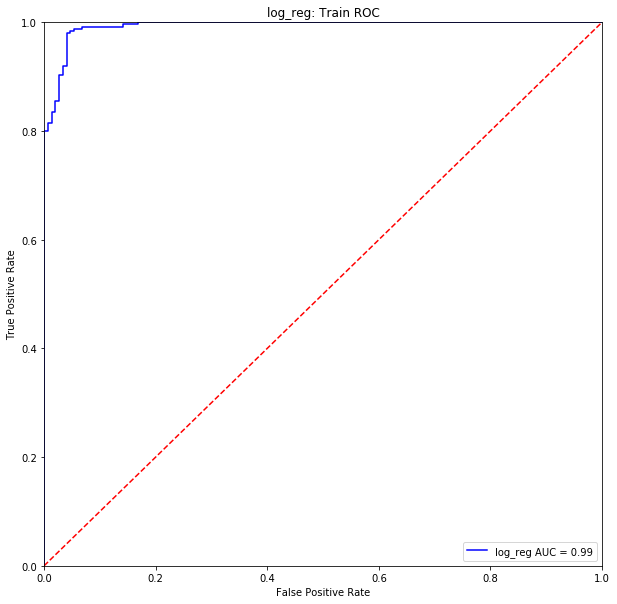

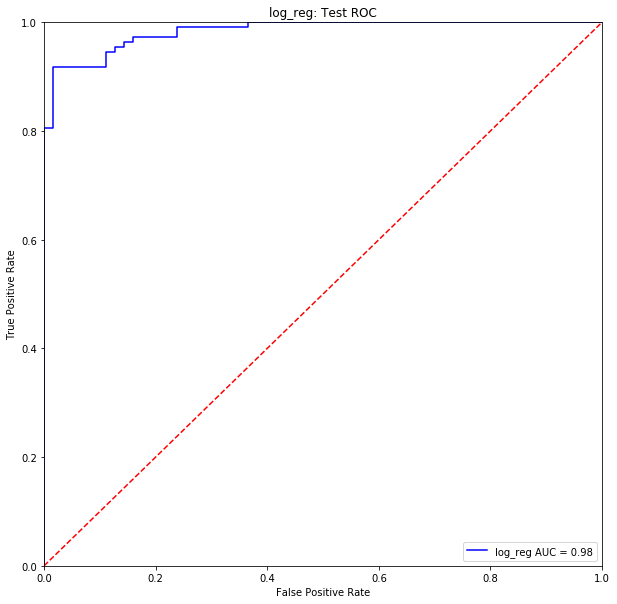

In [7]:
from sklearn.linear_model import LogisticRegression

# the following is roughly the same as:
# log_reg = LogisticRegression(C=1)
# log_reg.fit(split_result.X_train, split_result.y_train)
# log_reg.predict(split_result.X_test)
trava.fit_predict(raw_split_data=split_result,
                  model_id='log_reg',
                  model_type=LogisticRegression,
                  model_init_params={'C': 1},
                  serializer=serializer)

### Once again - extremely easy!

---

### Making sure that everything is tracked

In [8]:
import mlflow

In [9]:
experiment_id = mlflow.get_experiment_by_name('mlflow_demo').experiment_id
runs = mlflow.search_runs(experiment_ids=[experiment_id])
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,params.verbose,params.solver,params.dual,params.intercept_scaling,...,params.fit_intercept,params.tol,params.max_iter,params.penalty,params.warm_start,tags.mlflow.runName,tags.model_type,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type
0,3443a940f1f549e0a9629cd37b6b15a2,1,FINISHED,file:///Users/ilya.tyutin/Projects/trava/examp...,2020-05-24 14:40:57.018000+00:00,2020-05-24 14:40:57.318000+00:00,0,lbfgs,False,1,...,True,0.0001,100,l2,False,log_reg,LogisticRegression,/Users/ilya.tyutin/anaconda3/lib/python3.7/sit...,ilya.tyutin,LOCAL


### Examining the run

In [10]:
run = mlflow.get_run(runs.iloc[0]['run_id'])
run

<Run: data=<RunData: metrics={}, params={'C': '1',
 'dual': 'False',
 'fit_intercept': 'True',
 'intercept_scaling': '1',
 'max_iter': '100',
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'lbfgs',
 'tol': '0.0001',
 'verbose': '0',
 'warm_start': 'False'}, tags={'mlflow.runName': 'log_reg',
 'mlflow.source.name': '/Users/ilya.tyutin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'ilya.tyutin',
 'model_type': 'LogisticRegression'}>, info=<RunInfo: artifact_uri='file:///Users/ilya.tyutin/Projects/trava/examples/mlruns/1/3443a940f1f549e0a9629cd37b6b15a2/artifacts', end_time=1590331257318, experiment_id='1', lifecycle_stage='active', run_id='3443a940f1f549e0a9629cd37b6b15a2', run_uuid='3443a940f1f549e0a9629cd37b6b15a2', start_time=1590331257018, status='FINISHED', user_id='ilya.tyutin'>>

In [11]:
run.info.artifact_uri

'file:///Users/ilya.tyutin/Projects/trava/examples/mlruns/1/3443a940f1f549e0a9629cd37b6b15a2/artifacts'

^ you can find serialized model next to saved plots at the path 

Note: you should run the notebook by yourself to get the true path